# The Story of The Salton Sea

The Salton sea has been the sight of significant environmental upheaval in recent years as the lake dries up due to climate change. Week hope to explore more thoroughly what is happening in this area and how this impacts the community in the area.

In [1]:
# import packages

import pandas as pd
import geopandas as gpd

import plotly.express as px
import osmnx as ox

import matplotlib.pyplot as plt
import xyzservices.providers as xyz

import numpy as np
import rasterio
import rasterio.plot

# import plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import contextily as ctx



## Maggie's Stuff

Our first order of houskeeping is to establish the set of census tracts we want to use for plotting: "Our_FIPS"

In [2]:
## Set up some variables
Our_FIPs = [ '06025012301','06025010200',
               '06025010300','06025010400',
               '06025010500','06025010600',
               '06025010700','06025011000',
               '06025011300','06025011400',
               '06025011802','06025011202',
               '06025011201','06025010900',
               '06025010800','06025010300',
               '06025012400','06025010101',
               '06065045604','06065046900',
               '06065045609','06065045606',
               '06065940400','06065045216',
               '06065045304','06065045707',
               '06065045609','06065045605',
               '06065045608','06065045224',
               '06065045606','06065045608',
               '06065045605','06065044403',
               '06073021000','06025012301',
               '06065045605','06025011900',
               '06025011100','06025012302',
               '06025010102','06025011803',
               '06025011600','06025011801',
               '06025012200','06025012100',
               '06025012002','06025011700',
               '06025011500','06065045706',
               '06065045703','6065045705',
               '06065045704'
             ]

## Renewable Energy Development
Step One: Pull all data on power plants from open street map using set coordinates as geographic parameter and define that new data set as "osm_power"
Step Two: Set the crs to espg=4236
Steo Three: Plot osm_power
Step Four: Add the Esri.WorldImagry basemap

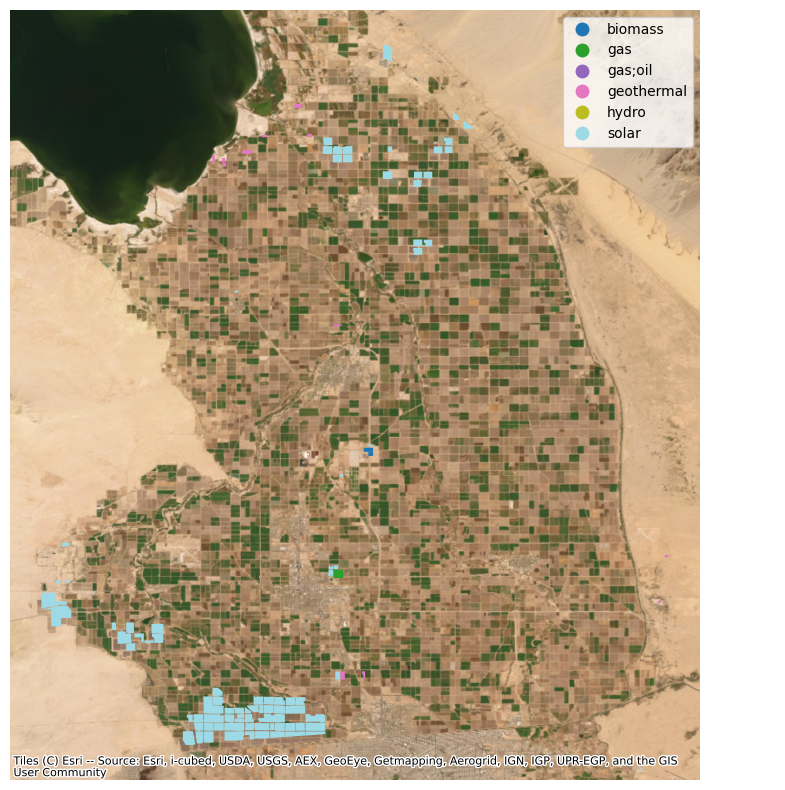

In [15]:
#Step One:
osm_power = ox.geometries_from_bbox(33.334227468796854, 32.65492287146084, -115.83365958918598, -115.25770254774852, tags={'power':'plant'})

#Step Two: 
osm_power = osm_power.to_crs(epsg=4236)
fig, ax = plt.subplots(figsize=(10,10))

#Step Three:
osm_power.plot(ax=ax,
         column='plant:source',
         cmap='tab20',
         legend=True)
ax.axis('off')

#Step Four: 
ctx.add_basemap(ax=ax,
                crs=osm_power.crs.to_string(),
                source=xyz.Esri.WorldImagery
                )

## Waterways in the Imperial Valley
Step One: Pull all data on waterways from open street map using set coordinates as geographic parameter and define that new data set as "osm_water" <br>
Step Two: Set the crs to espg=4236 <br>
Steo Three: Plot osm_water <br>
Step Four: Add the Esri.WorldImagry basemap

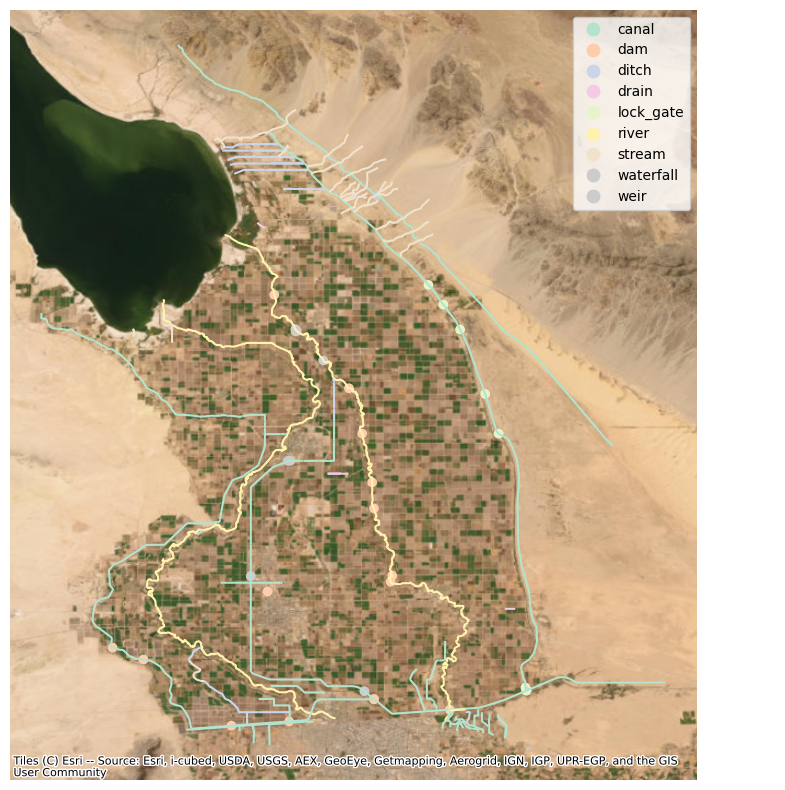

In [16]:

#Step One
osm_water = ox.geometries_from_bbox(33.334227468796854, 32.65492287146084, -115.83365958918598, -115.25770254774852, tags={'waterway':True})

#Step Two:
osm_water = osm_water.to_crs(epsg=4236)

#Step Three:
fig, ax = plt.subplots(figsize=(10,10))
osm_water.plot(ax=ax,
         column='waterway',
         cmap='Pastel2',
         legend=True)
ax.axis('off')

#Step Four:
ctx.add_basemap(ax=ax,
                crs=osm_power.crs.to_string(),
                source=xyz.Esri.WorldImagery
                )

## Asthma Mapping
Step One: Get the asthma data from calenviroscreen data<br>
Step Two: Clean up the FIPs Codes by changing to strings and adding leading zeros<br>
Step Three: Create a geodataframe that is just made up of the FIPs codes / census tracts we defined under above (see housekeeping)<br>
Step Four: Plot 'AsthmaP' variable from CalEnviroScreen over the Esri.WorldImgry Map <br>

- 'AsthmaP' variable describes how the rates in a given tract compares to other tracts across the state (percentile) <br>
- For example, a dark region in the 90th percentile means that the rates in that tract are higher than 90% of all other tracts<br>

Step Five: Plot Asthma variable from CalEnviroscreen over the Esri.WorldImagry Map <br>
- 'Asthma' variable is the number of trips to the emergency department per 10,000 people

(-116.98409285041606,
 -114.32948814952228,
 32.54557930245018,
 34.15294612860471)

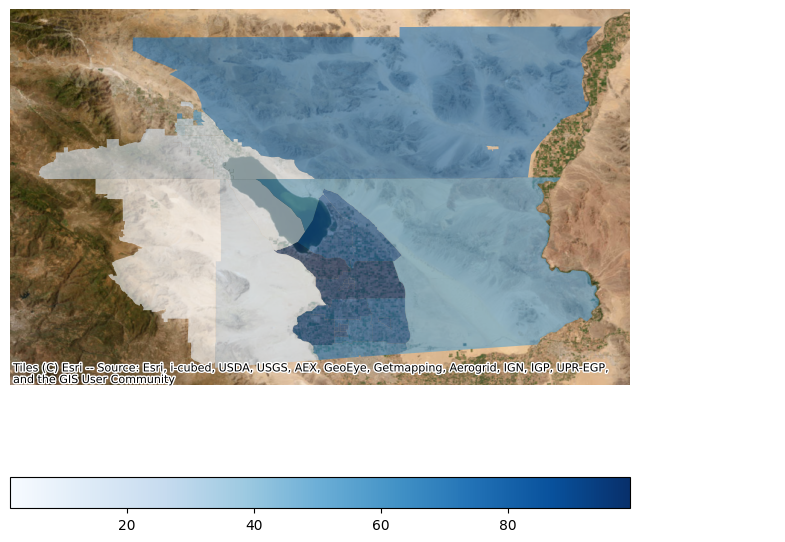

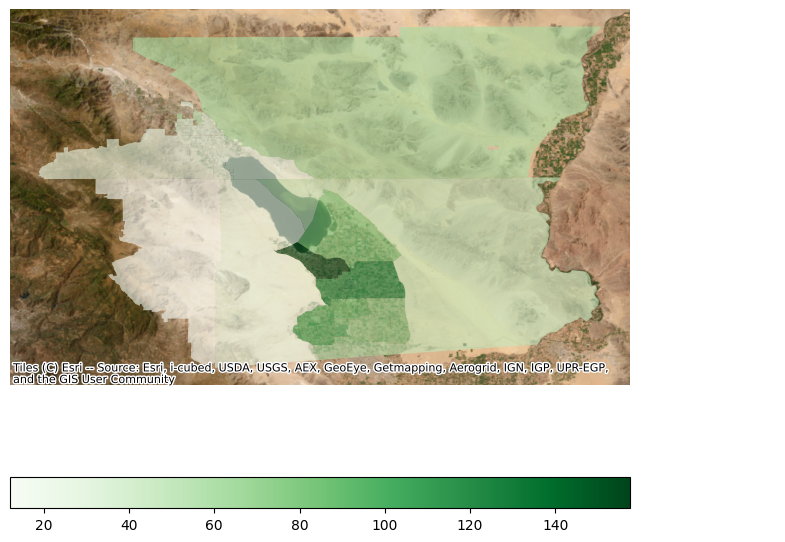

In [13]:
#Step One: 
calenviro_file = "data/CalEnviroScreen/calenviroscreen.zip"
calenviro = gpd.read_file(calenviro_file)

#Step Two:
calenviro['Tract'] = calenviro['Tract'].astype('int')
calenviro['Tract'] = calenviro['Tract'].astype('str')
calenviro["Tract"] = calenviro["Tract"].str.zfill(11)

#Step Three:
calenv_gdf= calenviro[calenviro['Tract'].isin(Our_FIPs)]

# Step Four:
calenv_gdf = calenv_gdf.to_crs(epsg=4236)
fig,ax = plt.subplots(figsize=(8,8))
calenv_gdf.plot(ax=ax,
               column='AsthmaP',
               legend=True,
               cmap='Blues',
               alpha=0.6,
              legend_kwds={"orientation": "horizontal"}
              )
ctx.add_basemap(ax=ax,
                crs=calenv_gdf.crs.to_string(),
                source=ctx.providers.Esri.WorldImagery
                )
ax.axis('off')

#Step Five:
calenv_gdf = calenv_gdf.to_crs(epsg=4236)
fig,ax = plt.subplots(figsize=(8,8))
calenv_gdf.plot(ax=ax,
               column='Asthma',
               legend=True,
               cmap='Greens',
               alpha=0.6,
              legend_kwds={"orientation": "horizontal"}
              )
ctx.add_basemap(ax=ax,
                crs=calenv_gdf.crs.to_string(),
                source=ctx.providers.Esri.WorldImagery
                )
ax.axis('off')

## Seth's Landcover Stuff

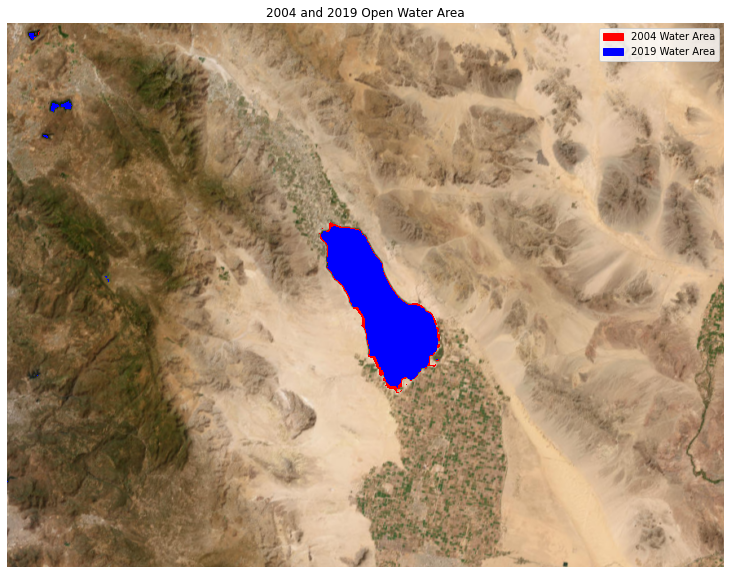

In [7]:
years = [2004, 2019] # create a list of the comparison years to loop over
data = {} # Create an empty dictionary to save the raster dataset to 
data_masked = {} # Create empty dictionary to save masked numpy array to

#Loop through years specified to create data needed to plot
for year in years:
    data[year] = rasterio.open(f'data/NLCD/NLCD_{str(year)}_Land_Cover_L48_20210604_gyGbthZM9gweVLuKaW5e.tiff') # open raster and create element in 'data' dict.
    data_masked[year] = np.ma.masked_where(data[year].read(1)!=11, data[year].read(1)) # mask raster to show only were data is '11' (Open Water)


# ### Mapping Change in Water Cover
# 
# Now that we have our data prepared and masked we can overlay the 2004 and 2019 data we can overlay them to highlight the areas where there used to be water but is now dry lakebed.

fig, ax = plt.subplots(figsize=(15,10)) # create a figure and axis object to map onto and set the figure size.
plt.imshow(data_masked[years[1]], extent=rasterio.plot.plotting_extent(data[years[1]]), cmap=ListedColormap(['blue']), zorder= 15) #plot data, set extent to geography, set color and drawing order
plt.imshow(data_masked[years[0]], extent=rasterio.plot.plotting_extent(data[years[0]]), cmap=ListedColormap(['red']), zorder= 10)

# creates legend items
handles = [
    Patch(color='red', label='2004 Water Area'),
    Patch(color='blue', label='2019 Water Area')
]

ctx.add_basemap(ax, crs=data[2004].read_crs(), source=ctx.providers.Esri.WorldImagery, zorder=5)
plt.axis('off')
plt.title('2004 and 2019 Open Water Area')
ax.legend(handles=handles)

plt.show()

In [8]:
count_19 = np.count_nonzero(data[2019].read(1) == 11)
count_04 = np.count_nonzero(data[2004].read(1) == 11)

sq_km = (count_04 - count_19)*900/1e6

print(f'The area surface area of water lost between 2004 and 2019 was {sq_km} square kilometers.')

The area surface area of water lost between 2004 and 2019 was 68.4603 square kilometers.


<bound method _AxesBase.get_xaxis of <AxesSubplot:xlabel='Land Cover', ylabel='Area of Land (square km)'>>

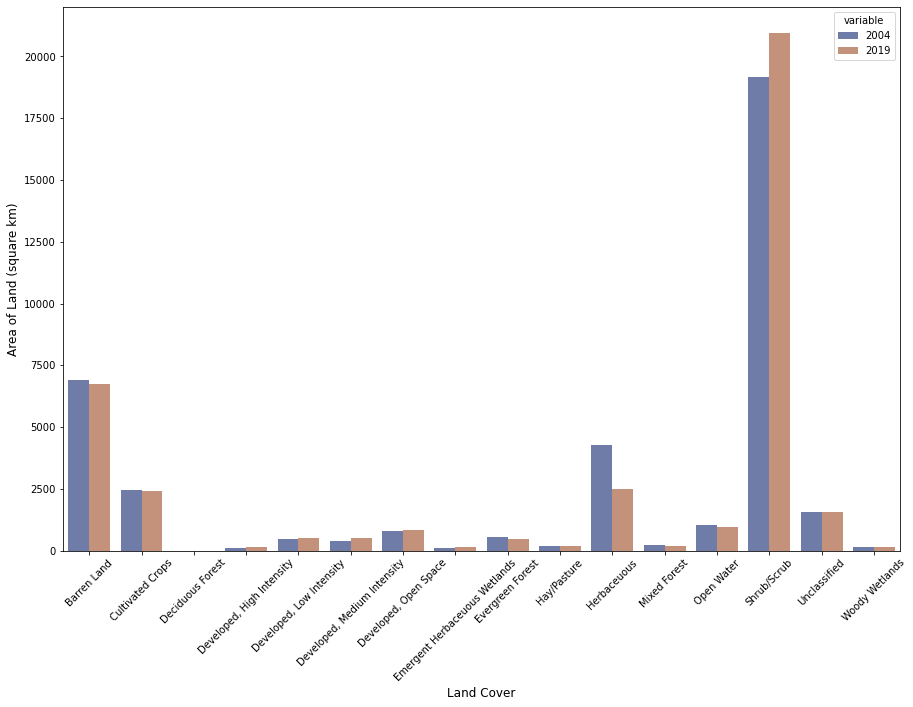

In [9]:
data_dict = pd.read_csv('data/NLCD/NLCD_landcover_legend_2018_12_17_gyGbthZM9gweVLuKaW5e.csv')
data_dict.dropna(axis=0, inplace=True) # Drop values with no legend information
legend = dict(zip(data_dict['Value'], data_dict['Legend'])) # save values and legend item as a dictionary for ease of use later.


# Create numpy arrays that are labeled instead of just as integers
labeled_data = {} #create an empty dict to fill
for year in years:
    labeled_data[year] = np.vectorize(legend.get)(data[year].read(1)) # fill dict item with np array where elements are labeled strings

# count cells of each land cover type for each year
counts_04 = np.unique(labeled_data[2004], return_counts=True)
counts_19 = np.unique(labeled_data[2019], return_counts=True)

# Create dataframe with landcover type and count for each year
df = pd.DataFrame(list(zip(counts_04[0],counts_04[1], counts_19[1])), columns=['landcover', '2004', '2019']) 
df['2004'] = df['2004']*900/1e6 # calculate as area in sq km
df['2019'] = df['2019']*900/1e6
df.head()

# %%
df_long = pd.melt(df, id_vars='landcover', value_vars=['2004','2019']) # convert to a "long" data frame that is better for plotting side by side

# %%
# Plot the land cover area as a bar chart side by side
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,10))

sns.barplot( 
    ax=ax, data=df_long,
    x='landcover', y='value', hue='variable',
    palette='dark', alpha=.6,
)
plt.xlabel('Land Cover', fontsize=12)
plt.ylabel('Area of Land (square km)', fontsize=12)
plt.xticks(rotation=45)
ax.get_xaxis

## Miriam's Stuff

## Tiffany's Stuff

## Exploring the proportion of land that is considered to be in a drought in Imperial, San Diego & Riverside County
## Data was obtained from US Drought Monitoring System

Next I upload my data, and inspect it to ensure that it has loaded properly.

In [10]:
import datetime #import necessary datetime type

countydf=pd.read_csv('data/Drought/RiversideImperialDrought.csv', parse_dates=['ValidStart']) #import data and read a date field as a datetime type
countydf.set_index('ValidStart',inplace=True) #set date field as index for plotting

countydf.head() #examine the data

MapDate  FIPS           County State  None     D0     D1   D2  \
ValidStart                                                                   
2023-02-07  20230207  6025  Imperial County    CA   0.0  47.65  52.35  0.0   
2023-01-31  20230131  6025  Imperial County    CA   0.0  47.65  52.35  0.0   
2023-01-24  20230124  6025  Imperial County    CA   0.0  47.65  52.35  0.0   
2023-01-17  20230117  6025  Imperial County    CA   0.0  47.65  52.35  0.0   
2023-01-10  20230110  6025  Imperial County    CA   0.0  47.65  52.35  0.0   

             D3   D4    ValidEnd  StatisticFormatID  
ValidStart                                           
2023-02-07  0.0  0.0  2023-02-13                  2  
2023-01-31  0.0  0.0  2023-02-06                  2  
2023-01-24  0.0  0.0  2023-01-30                  2  
2023-01-17  0.0  0.0  2023-01-23                  2  
2023-01-10  0.0  0.0  2023-01-16                  2

The way this data is structured, each record shows the percentage of the area of the county in a given level of drought (from D0 to D4) at a time. To show this we can show the approximate levels of drought in a given county over time.

We create a function that will create a stacked area plot to showcase the portion of the county in a given level of drought at a given time. I can then call this function in a loop to return a graph for each county in the data.

In [11]:
def drought_graph(df:pd.DataFrame, county:str):
    """
    Graph Levels of drought over time for a given county

    df -- Pandas Dataframe with D0 through D4 drought levels
    county -- string with county name
    """
    df = df[df['County']==county]
    fig, ax = plt.subplots(figsize=(12,8))
    df[['D0', 'D1','D2', 'D3', 'D4']].plot.area(ax=ax)

    plt.xlabel('Date')
    plt.ylabel('Percentage of County Area in Drought')

    plt.title(f'{county} Drought Level Over Time')

Now that we have a function we can create a list of the counties we need and loop through this list to create graphs for each county.

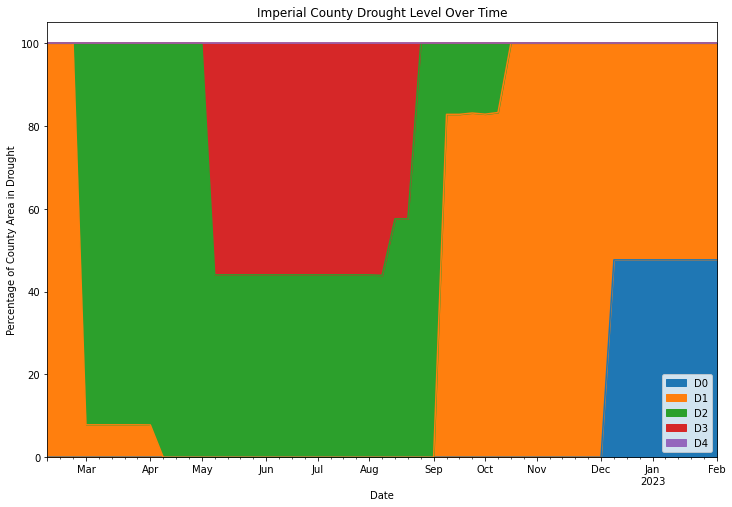

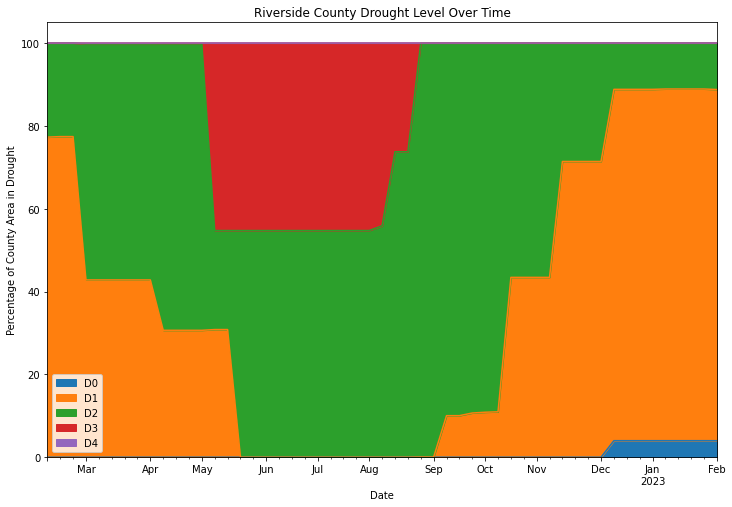

In [12]:
counties = countydf['County'].unique() #create a list of counties in the dataset to loop over

for county in counties: #loop through the counties and graph
    drought_graph(countydf, county=county)